# Exploratory Data Analysis

In [1]:
# | echo: false
%load_ext lab_black

Import Python modules

In [2]:
import os
from calendar import day_name, month_name
from datetime import datetime
from glob import glob
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
from feature_engine.encoding import RareLabelEncoder
from google.oauth2 import service_account
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

## About

This step of the analysis explores the visit data for the Google Merchandise store on the Google Marketplace, based on learnings from the data preparation step.

### Objectives
The goals of this step in the analysis are the following

1. explore the prepared data to look for any underlying patterns that can be captured through features that might help ML modeling
2. observe the class imbalance of the labels (`y`) to get a sense of any resampling techniques that could aid the performance of a ML model

### Discussion of Study Period for This Project
Same as for data preparation.

### Data Selection for EDA
With the above in mind, EDA in this step will cover the training data.

### Business Questions for EDA
We will explore this dataset by answering the following (non-exhaustive) set of business-relevant questions

1. For [high-level channel](https://www.megalytic.com/blog/understanding-google-analytics-channels), and the [more fine-graned traffic source and traffic medium](https://www.propellernet.co.uk/what-is-the-difference-between-source-medium-in-google-analytics/), get the correlation between the numerical attributes of visits and total visit revenue. Across all of these groupings of sources of web traffic arriving at the merchandise store, comment on the strongest and weakest correlations to revenue.
2. Which channels were responsible for the most first-visitors with a purchase on their return visit? Show this comparison on a chart by channel.
3. Is there any one web-browser that return purchasers used on their first visit?
4. Do visitors who make a purchase on their return visit to the store have a preference for the type of device they are using (desktop, mobile, etc.)?
5. Which traffic sources were responsible for the most return purchasers on weekdays and weekends?
6. Show the fraction of visitors who did make a purchase on their return visit to the merchandise store by month and day of the month.
7. Show the fraction of visitors who made a purchase on their return visit to the merchandise store by month and day of the week.
8. Show the breakdown of total revenue earned by visitors who are return purchasers and those that are not return purchasers.

## User Inputs

Get relative path to project root directory

In [3]:
# | code-fold: false
PROJ_ROOT_DIR = os.path.join(os.pardir)

Define the following

1. train data start date
2. train data end date
3. test data end date

In [4]:
# | code-fold: false
train_start_date = "20160901"
train_end_date = "20161231"
test_end_date = "20170228"

# categorical column names
categorical_columns = [
    "bounces",
    "last_action",
    "source",
    "medium",
    "channelGrouping",
    "browser",
    "os",
    "deviceCategory",
]

# categorical columns to be grouped
cols_to_group = {
    "5_pct": ["source", "browser"],
    "10_pct": ["os", "channelGrouping", "medium"],
}

Retrieve credentials for `bigquery` client

In [5]:
# | code-fold: false
# Google Cloud PROJECT ID
gcp_project_id = os.environ["GCP_PROJECT_ID"]

Get filepath to Google Cloud Service Account JSON key

In [6]:
# | code-fold: false
raw_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "raw")
gcp_creds_fpath = glob(os.path.join(raw_data_dir, "*.json"))[0]

Authenticate `bigquery` client and get dictionary with credentials

In [7]:
# | code-fold: false
gcp_credentials = service_account.Credentials.from_service_account_file(gcp_creds_fpath)
gcp_auth_dict = dict(gcp_project_id=gcp_project_id, gcp_creds=gcp_credentials)

Create a mapping between action type integer and label, in order to get meaningful names from the `action_type` column

In [8]:
# | code-fold: false
mapper = {
    1: "Click through of product lists",
    2: "Product detail views",
    3: "Add product(s) to cart",
    4: "Remove product(s) from cart",
    5: "Check out",
    6: "Completed purchase",
    7: "Refund of purchase",
    8: "Checkout options",
    0: "Unknown",
}

Define a dictionary to change datatypes of prepared data (this was originally developed in the data preparation step)

In [9]:
# | code-fold: false
dtypes_dict = {
    "fullvisitorid": pd.StringDtype(),
    "visitId": pd.StringDtype(),
    "visitNumber": pd.Int8Dtype(),
    "country": pd.StringDtype(),
    "quarter": pd.Int8Dtype(),
    "month": pd.Int8Dtype(),
    "day_of_month": pd.Int8Dtype(),
    "day_of_week": pd.Int8Dtype(),
    "hour": pd.Int8Dtype(),
    "minute": pd.Int8Dtype(),
    "second": pd.Int8Dtype(),
    "source": pd.CategoricalDtype(),  #
    "medium": pd.CategoricalDtype(),  #
    "channelGrouping": pd.CategoricalDtype(),  #
    "hits": pd.Int16Dtype(),
    "bounces": pd.CategoricalDtype(),  #
    "last_action": pd.CategoricalDtype(),  #
    "product_detail_views": pd.Int16Dtype(),
    "promos_displayed": pd.Int16Dtype(),
    "promos_clicked": pd.Int16Dtype(),
    "product_views": pd.Int16Dtype(),
    "product_clicks": pd.Int16Dtype(),
    "pageviews": pd.Int16Dtype(),
    "transact_revenue": pd.Float32Dtype(),
    "time_on_site": pd.Int16Dtype(),
    "browser": pd.CategoricalDtype(),  #
    "os": pd.CategoricalDtype(),  #
    "added_to_cart": pd.Int16Dtype(),
    "deviceCategory": pd.CategoricalDtype(),  #
}

Define a Python helper functions to perform the following

1. execute a SQL query using Google BigQuery
2. set column datatypes of a `pandas.DataFrame`
3. drop duplicates based on a list of columns in a `pandas.DataFrame`
4. customize the axes of a `matplotlib` plot
5. plot a [faceted bar chart using `seaborn`](https://stackoverflow.com/a/35234137/4057186)
6. plot a heatmap using `seaborn`

In [10]:
# | code-fold: false
def run_sql_query(
    query: str,
    gcp_project_id: str,
    gcp_creds: os.PathLike,
    show_dtypes: bool = False,
    show_info: bool = False,
    show_df: bool = False,
) -> pd.DataFrame:
    """Run query on BigQuery and return results as pandas.DataFrame."""
    start_time = datetime.now(pytz.timezone("US/Eastern"))
    start_time_str = start_time.strftime("%Y-%m-%d %H:%M:%S.%f")
    print(f"Query execution start time = {start_time_str[:-3]}...", end="")
    df = pd.read_gbq(
        query,
        project_id=gcp_project_id,
        credentials=gcp_creds,
        dialect="standard",
        # configuration is optional, since default for query caching is True
        configuration={"query": {"useQueryCache": True}},
        # use_bqstorage_api=True,
    )
    end_time = datetime.now(pytz.timezone("US/Eastern"))
    end_time_str = end_time.strftime("%Y-%m-%d %H:%M:%S.%f")
    duration = end_time - start_time
    duration = duration.seconds + (duration.microseconds / 1_000_000)
    print(f"done at {end_time_str[:-3]} ({duration:.3f} seconds).")
    print(f"Query returned {len(df):,} rows")
    if show_df:
        with pd.option_context("display.max_columns", None):
            display(df)
    if show_dtypes:
        display(df.dtypes.rename("dtype").to_frame().transpose())
    if show_info:
        df.info()
    return df


def set_datatypes(df: pd.DataFrame, dtypes: Dict) -> pd.DataFrame:
    """Set DataFrame datatypes using dictionary."""
    df = df.astype(dtypes)
    return df


def drop_duplicates(df: pd.DataFrame, subset: List[str]) -> pd.DataFrame:
    """Drop duplicates."""
    df = df.drop_duplicates(subset=subset, keep="first")
    return df


def customize_splines(ax: plt.axis, edgecolor: str = "grey") -> plt.axis:
    """Customize matplotlib axis properties."""
    ax.spines["left"].set_edgecolor(edgecolor)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_edgecolor(edgecolor)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["top"].set_edgecolor(None)
    ax.spines["right"].set_edgecolor(None)
    ax.tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
        labelleft=True,
        labelbottom=True,
    )
    return ax


def plot_faceted_grouped_bar_chart(
    data: pd.DataFrame,
    xvar: str,
    yvar: str,
    zvar: str,
    color_by_col: str,
    colors: List[str],
    xvar_type: str,
    high_corr_categories: List[str],
    bar_order: List[str],
) -> None:
    """Plot faceted grouped bar chart."""
    g = sns.FacetGrid(
        data,
        row=zvar,
        hue=color_by_col,
        palette=colors,
        height=3,
        sharey=False,
        sharex=False,
        aspect=3,
    )
    g.map(sns.barplot, xvar, yvar, order=bar_order)
    g.fig.tight_layout(h_pad=-2)

    # flatten axes into a 1-d array
    axes = g.axes.flatten()

    # iterate through the axes
    for k, ax in enumerate(axes):
        zvar_attr = ax.get_title().split(" = ")[-1]
        z_value_min = data.query(f"{zvar} == '{zvar_attr}'")[yvar].min()

        ax.set_xlabel(None)
        ax.set_ylabel(zvar_attr.title().replace("_", " "), fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.tick_params(size=0)
        ax = customize_splines(ax, None)
        if z_value_min < 0:
            ax.axhline(0, ls="--", c="black")
        ax.set_title(None)
        ptitle = (
            "Highest correlation to revenue is for "
            f"{', '.join(high_corr_categories)} {xvar_type}"
        )
        if k == 0:
            ax.set_title(ptitle, fontweight="bold", loc="left")
        if k in range(len(bar_order)):
            ax.set_xticklabels([])


def show_heatmap(
    data: pd.DataFrame,
    ytitle: str,
    ptitle: str,
    cbar_params: Union[Dict[str, float], bool] = False,
    annot_kws: Union[Dict[str, int], bool] = False,
    fig_size: Tuple[int] = (10, 12),
) -> None:
    """."""
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(
        data,
        cmap="YlOrRd",
        linewidth=0.5,
        cbar=True if cbar_params else None,
        cbar_kws=cbar_params if cbar_params else None,
        annot=True if annot_kws else None,
        annot_kws=annot_kws if annot_kws else None,
        ax=ax,
    )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(ytitle, fontsize=12)
    if cbar_params:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(size=0, labelsize=12)
    ax.tick_params(size=0)
    ax.set_title(
        ptitle,
        loc="left",
        fontsize=11,
        fontweight="bold",
    )

## Get and Prepare Data

Data will be prepared for EDA based on our learnings from the data preparation step
1. SQL to get the following for visitors who made a return (future) visit to the merchandise store during the months to be included in the training data split
   - attributes of their first visit
     - these are candidate features (`X`) for use in ML development
     - one visitor is present per row
   - forward-looking label (`y`) that indicates if each visitor made a purchase on a return visit to the store
     - one visitor is present per row
2. drop duplicates by `fullvisitorid`
3. set column datatypes for all columns

These three steps are enclosed into a `pandas.pipeline` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pipe.html)), which is defined below

In [11]:
# | code-fold: false
query = f"""
        WITH
        -- Step 1. get visitors with a purchase on a future visit
        next_visit_purchasers AS (
             SELECT fullvisitorid,
                    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, True, False) AS made_purchase_on_future_visit
             FROM `data-to-insights.ecommerce.web_analytics`
             WHERE date BETWEEN '{train_start_date}' AND '{test_end_date}'
             AND geoNetwork.country = 'United States'
             GROUP BY fullvisitorid
        ),
        -- Steps 2. and 3. get attributes of the first visit
        first_visit_attributes AS (
            SELECT -- =========== GEOSPATIAL AND TEMPORAL ATTRIBUTES OF VISIT ===========
                   geoNetwork.country,
                   EXTRACT(QUARTER FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS quarter,
                   EXTRACT(MONTH FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS month,
                   EXTRACT(DAY FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS day_of_month,
                   EXTRACT(DAYOFWEEK FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS day_of_week,
                   EXTRACT(HOUR FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS hour,
                   EXTRACT(MINUTE FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS minute,
                   EXTRACT(SECOND FROM DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern')) AS second,
                   -- =========== VISIT AND VISITOR METADATA ===========
                   fullvisitorid,
                   visitId,
                   visitNumber,
                   DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Eastern') AS visitStartTime,
                   -- =========== SOURCE OF SITE TRAFFIC ===========
                   -- source of the traffic from which the visit was initiated
                   trafficSource.source,
                   -- medium of the traffic from which the visit was initiated
                   trafficSource.medium,
                   -- referring channel connected to visit
                   channelGrouping,
                   -- =========== VISITOR ACTIVITY ===========
                   -- total number of hits
                   (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                   -- number of bounces
                   (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                   -- action performed during first visit
                   CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                   -- page views
                   IFNULL(totals.pageviews, 0) AS pageviews,
                   -- total revenue
                   totals.totalTransactionRevenue / 1000000 AS transact_revenue,
                   -- time on the website
                   IFNULL(totals.timeOnSite, 0) AS time_on_site,
                   -- whether add-to-cart was performed during visit
                   (CASE WHEN CAST(h.eCommerceAction.action_type AS INT64) = 3 THEN 1 ELSE 0 END) AS added_to_cart,
                   (CASE WHEN CAST(h.eCommerceAction.action_type AS INT64) = 2 THEN 1 ELSE 0 END) AS product_details_viewed,
                   -- =========== VISITOR DEVICES ===========
                   -- user's browser
                   device.browser,
                   -- user's operating system
                   device.operatingSystem AS os,
                   -- user's type of device
                   device.deviceCategory,
                   -- =========== PROMOTION ===========
                   h.promotion,
                   h.promotionActionInfo AS pa_info,
                   -- =========== PRODUCT ===========
                   h.product,
                   -- =========== ML LABEL (DEPENDENT VARIABLE) ===========
                   made_purchase_on_future_visit
            FROM `data-to-insights.ecommerce.web_analytics`,
            UNNEST(hits) AS h
            INNER JOIN next_visit_purchasers USING (fullvisitorid)
            WHERE date BETWEEN '{train_start_date}' AND '{train_end_date}'
            AND geoNetwork.country = 'United States'
            AND totals.newVisits = 1
        ),
        -- Step 4. get aggregated features (attributes) per visit
        visit_attributes AS (
            SELECT fullvisitorid,
                   visitId,
                   visitNumber,
                   visitStartTime,
                   country,
                   quarter,
                   month,
                   day_of_month,
                   day_of_week,
                   hour,
                   minute,
                   second,
                   source,
                   medium,
                   channelGrouping,
                   hits,
                   bounces,
                   -- get the last action performed during the first visit
                   -- (this indicates where the visitor left off at the end of their visit)
                   MAX(action_type) AS last_action,
                   -- get number of products whose details were viewed
                   SUM(product_details_viewed) AS product_detail_views,
                   -- get number of promotions displayed and clicked during the first visit
                   COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsView ELSE NULL END) AS promos_displayed,
                   COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsClick ELSE NULL END) AS promos_clicked,
                   -- get number of products displayed and clicked during the first visit
                   COUNT(CASE WHEN pu.isImpression IS NULL THEN NULL ELSE 1 END) AS product_views,
                   COUNT(CASE WHEN pu.isClick IS NULL THEN NULL ELSE 1 END) AS product_clicks,
                   pageviews,
                   transact_revenue,
                   time_on_site,
                   browser,
                   os,
                   deviceCategory,
                   SUM(added_to_cart) AS added_to_cart,
                   made_purchase_on_future_visit,
            FROM first_visit_attributes
            LEFT JOIN UNNEST(promotion) as p
            LEFT JOIN UNNEST(product) as pu
            GROUP BY fullvisitorid,
                     visitId,
                     visitNumber,
                     visitStartTime,
                     country,
                     quarter,
                     month,
                     day_of_month,
                     day_of_week,
                     hour,
                     minute,
                     second,
                     source,
                     medium,
                     channelGrouping,
                     hits,
                     bounces,
                     pageviews,
                     transact_revenue,
                     time_on_site,
                     browser,
                     os,
                     deviceCategory,
                     made_purchase_on_future_visit
        )
        SELECT *
        FROM visit_attributes
        """
df = (
    run_sql_query(query, **gcp_auth_dict, show_df=False)
    .pipe(set_datatypes, dtypes=dtypes_dict)
    .pipe(drop_duplicates, subset=["fullvisitorid"])
)
with pd.option_context("display.max_columns", None):
    display(df.head())
    display(df.tail())

Query execution start time = 2023-04-12 22:16:47.745...done at 2023-04-12 22:17:06.333 (18.589 seconds).
Query returned 92,859 rows


,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,minute,second,source,medium,channelGrouping,hits,bounces,last_action,product_detail_views,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,transact_revenue,time_on_site,browser,os,deviceCategory,added_to_cart,made_purchase_on_future_visit
0,483329569933708956,1477437687,1,2016-10-25 19:21:27,United States,4,10,25,3,19,21,27,google,organic,Organic Search,6,0,0,0,0,0,0,0,6,<NA>,602,Chrome,Windows,desktop,0,False
1,9534112552538425546,1476671570,1,2016-10-16 22:32:50,United States,4,10,16,1,22,32,50,youtube.com,referral,Social,6,0,0,0,54,0,0,0,1,<NA>,270,Opera,Windows,desktop,0,False
2,4648924122067625674,1475958245,1,2016-10-08 16:24:05,United States,4,10,8,7,16,24,5,youtube.com,referral,Social,5,0,0,0,36,0,4,0,2,<NA>,198,Opera,Windows,desktop,0,False
3,2743152869399749836,1481229164,1,2016-12-08 15:32:44,United States,4,12,8,5,15,32,44,google,organic,Organic Search,5,0,0,0,18,0,0,0,5,<NA>,1004,Chrome,Windows,desktop,0,False
4,1565213706199847638,1475172212,1,2016-09-29 14:03:32,United States,3,9,29,5,14,3,32,google,organic,Organic Search,5,0,0,0,18,0,15,0,5,<NA>,107,Chrome,Android,mobile,0,False


,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,minute,second,source,medium,channelGrouping,hits,bounces,last_action,product_detail_views,promos_displayed,promos_clicked,product_views,product_clicks,pageviews,transact_revenue,time_on_site,browser,os,deviceCategory,added_to_cart,made_purchase_on_future_visit
92854,116047731488418420,1481947293,1,2016-12-16 23:01:33,United States,4,12,16,6,23,1,33,google,organic,Organic Search,4,0,0,0,0,0,40,0,4,<NA>,41,Internet Explorer,Windows,desktop,0,False
92855,4456968726181345855,1475469647,1,2016-10-03 00:40:47,United States,4,10,3,2,0,40,47,google,organic,Organic Search,4,0,0,0,0,0,48,0,4,<NA>,116,Safari,Macintosh,desktop,0,False
92856,3959327314706060020,1482846670,1,2016-12-27 08:51:10,United States,4,12,27,3,8,51,10,google,organic,Organic Search,4,0,0,0,0,0,43,0,4,<NA>,77,Chrome,Android,mobile,0,False
92857,3020400276554321201,1478988254,1,2016-11-12 17:04:14,United States,4,11,12,7,17,4,14,google,organic,Organic Search,4,0,0,0,0,0,48,0,4,<NA>,61,Internet Explorer,Windows,desktop,0,False
92858,7677161554293089105,1481515229,1,2016-12-11 23:00:29,United States,4,12,11,1,23,0,29,google,organic,Organic Search,4,0,0,0,0,0,44,0,4,<NA>,31,Chrome,Macintosh,desktop,0,False


Get a list of the non-categorical columns

In [12]:
# | code-fold: false
non_categorical_columns = [c for c in list(df) if c not in categorical_columns]

Show the number of unique values in all categorical columns

In [13]:
df_nunique = pd.DataFrame.from_records(
    [{"column": c, "num_unique_values": df[c].nunique()} for c in categorical_columns]
)
df_nunique

,column,num_unique_values
0,bounces,2
1,last_action,7
2,source,116
3,medium,7
4,channelGrouping,8
5,browser,26
6,os,15
7,deviceCategory,3


Define a custom data transformation pipeline to handle the categorical columns. In the data preparation step, this was done using `pandas.value_counts()` to drop in frequently occurring values based on two thresholds for minimum wanted frequency 5% and 10%. Here, we will define a custom `scikit-learn.pipeline` that performs the same encoding using the `feature-engine` [library](https://pypi.org/project/feature-engine/), which provides a `RareLabelEncoder` that accepts a threshold as the parameter `tol`. Two such encoders are defined below with the required thresholds and they are then placed into a `scikit-learn.pipeline` to transform the data

In [14]:
# | code-fold: false
encoder_05 = RareLabelEncoder(
    tol=0.05,
    n_categories=2,
    variables=[v for k, v in cols_to_group.items() if "5" in k][0],
    replace_with="other",
)
encoder_10 = RareLabelEncoder(
    tol=0.10,
    n_categories=2,
    variables=[v for k, v in cols_to_group.items() if "10" in k][0],
    replace_with="other",
)
categorical_transformer = Pipeline(
    steps=[("enc_05", encoder_05), ("enc_10", encoder_10)]
)
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_columns)],
    remainder="passthrough",
)
pipe_trans = Pipeline(steps=[("preprocessor", preprocessor)])
pipe_trans

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('enc_05',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='other',
                                                                                    variables=['source',
                                                                                               'browser'])),
                                                                  ('enc_10',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='other',
                                                                                    tol=0.1,
                                                                                    variables=['os',
                                                                                               'channelGrouping',
                                                                                               'medium']))]),
                                                  ['bounces', 'last_action',
                                                   'source', 'medium',
                                                   'channelGrouping', 'browser',
                                                   'os',
                                                   'deviceCategory'])]))])

::: {.callout-note title="Notes"}

1. The datatype of the categorical columns is set as `pd.CategoricalDtype()` in the datatypes dictionary `dtypes_dict` earlier. This was set as `pd.StringDtype()` during the data preparation step. Here, this change is necessary since the `RareLabelEncoder()` transformer expects to see these categrical columns appear as categories and not just as strings.
:::

Apply the custom data transformation pipeline to prepare the training data split for EDA

In [15]:
# | code-fold: false
_ = pipe_trans.fit(df)
df = pd.DataFrame(
    pipe_trans.transform(df), columns=categorical_columns + non_categorical_columns
)[non_categorical_columns + categorical_columns].pipe(set_datatypes, dtypes=dtypes_dict)

The cardinality of the columns before and after grouping is shown below

In [16]:
df_nunique.merge(
    pd.DataFrame.from_records(
        [
            {
                "column": c,
                "column_grouped": c,
                "num_unique_values_after_grouping": df[c].nunique(),
            }
            for c in categorical_columns
        ]
    ).assign(column_grouped=lambda df: df["column_grouped"] != df["column"]),
    on=["column"],
    how="left",
)

,column,num_unique_values,column_grouped,num_unique_values_after_grouping
0,bounces,2,False,2
1,last_action,7,False,7
2,source,116,False,5
3,medium,7,False,4
4,channelGrouping,8,False,4
5,browser,26,False,3
6,os,15,False,5
7,deviceCategory,3,False,3


::: {.callout-tip title="Observations"}

1. This is identical to the output seen during the data preparation step in the **Handling Categorical Columns** sub-section.
:::

The category distributions (frequencies) after grouping are shown below for all categorical columns (including those that were grouped)

In [17]:
dfs_cats_groups = []
for c in categorical_columns:
    # get fraction of unique values
    df_frequencies = (
        df[c]
        .value_counts()
        .rename("number_of_visitors")
        .to_frame()
        .merge(
            (
                df[c].value_counts(normalize=True).rename("fraction_of_visitors") * 100
            ).to_frame(),
            left_index=True,
            right_index=True,
        )
    )

    # map unique values for last_action and bounces to get meaningful names
    if c == "last_action":
        df_frequencies.index = df_frequencies.index.map(mapper)
    if c == "bounces":
        df_frequencies.index = df_frequencies.index.map({0: False, 1: True})

    # get running total of fraction (cumulative sum)
    df_frequencies = (
        df_frequencies.sort_values(by=["fraction_of_visitors"])
        .assign(
            cumulative_fraction_of_visitors=lambda df: df[
                "fraction_of_visitors"
            ].cumsum(),
            column_name=c,
        )
        .sort_values(by=["fraction_of_visitors"], ascending=False)
    )

    # rename columns
    df_frequencies = df_frequencies.reset_index().rename(columns={c: "column_value"})
    dfs_cats_groups.append(df_frequencies)
df_frequencies_grouped = pd.concat(dfs_cats_groups, ignore_index=True)
col = df_frequencies_grouped.pop("column_name")
df_frequencies_grouped.insert(0, col.name, col)
with pd.option_context("display.max_rows", None):
    display(df_frequencies_grouped)

,column_name,column_value,number_of_visitors,fraction_of_visitors,cumulative_fraction_of_visitors
0,bounces,False,65500,70.771791,100.000000
1,bounces,True,27051,29.228209,29.228209
2,last_action,Unknown,67519,72.953291,100.000000
3,last_action,Product detail views,14720,15.904744,27.046709
4,last_action,Add product(s) to cart,4663,5.038303,11.141965
5,last_action,Completed purchase,3094,3.343022,6.103662
6,last_action,Check out,1632,1.763352,2.760640
7,last_action,Remove product(s) from cart,882,0.952988,0.997288
8,last_action,Click through of product lists,41,0.044300,0.044300
9,source,google,43478,46.977342,100.000000


::: {.callout-tip title="Observations"}

1. This is identical to the output seen in `df_frequencies_grouped` during the data preparation step in the **Handling Categorical Columns** sub-section.
:::

The training data split is now prepared and ready for use in EDA.

## Exploratory Data Analysis

::: {.callout-note title="Notes"}

1. We will interchangeably refer to each row in the data that was prepared above as visits or visitors. Since duplicates by `fullvisitorid` have been dropped, each row represents a unique visitor.
2. For the rest of this step (EDA), we will only use the training data as mentioned earlier in order to avoid data leakage or lookahead bias.
3. We will interchangeably refer to each visitor who made a purchase on a return visit as a return purchaser.
:::

The first few rows of the prepared training data are shown below

In [18]:
with pd.option_context("display.max_rows", None):
    display(df.head())

,fullvisitorid,visitId,visitNumber,visitStartTime,country,quarter,month,day_of_month,day_of_week,hour,...,added_to_cart,made_purchase_on_future_visit,bounces,last_action,source,medium,channelGrouping,browser,os,deviceCategory
0,483329569933708956,1477437687,1,2016-10-25 19:21:27,United States,4,10,25,3,19,...,0,False,0,0,google,organic,Organic Search,Chrome,Windows,desktop
1,9534112552538425546,1476671570,1,2016-10-16 22:32:50,United States,4,10,16,1,22,...,0,False,0,0,youtube.com,referral,other,other,Windows,desktop
2,4648924122067625674,1475958245,1,2016-10-08 16:24:05,United States,4,10,8,7,16,...,0,False,0,0,youtube.com,referral,other,other,Windows,desktop
3,2743152869399749836,1481229164,1,2016-12-08 15:32:44,United States,4,12,8,5,15,...,0,False,0,0,google,organic,Organic Search,Chrome,Windows,desktop
4,1565213706199847638,1475172212,1,2016-09-29 14:03:32,United States,3,9,29,5,14,...,0,False,0,0,google,organic,Organic Search,Chrome,Android,mobile


::: {.callout-note title="Notes"}

1. For the categorical columns, only the frequency-encoded versions are present in the prepared data.
:::

**Question 1. For high-level channel, and the more fine-graned traffic source and traffic medium, get the correlation between the numerical attributes of visits and total visit revenue. Across all of these groupings of sources of web traffic arriving at the merchandise store, comment on the strongest and weakest correlations to revenue.**

At the time of the first visit, we know whether the visitor will make a purchase during a return (or future) visit to the merchandise store. This is in the `made_purchase_on_future_visit` column. But, we have not extracted the visit revenue that was earned during that future visit, since we have only extracted its outcome. So, we will assume that this question is referring to visit revenue earned during the first visit since the columns (including `totals.transact_revenue`) are only retrieved for visitors' first visits.

Due to the high cardinality of channel and traffic source, this question will be answered for the grouped version of these columns. The following helper function will [get this correlation](https://stackoverflow.com/a/74492236/4057186) and will be re-used for all three traffic-related columns

In [19]:
# | code-fold: false
def get_revenue_corr_by_attribute(
    df: pd.DataFrame, categorical_col: str, numerical_cols: List[str]
) -> pd.DataFrame:
    """Get correlation between numerical attrs and revenue for categorical attribute."""
    # get distribution of categorical column
    df_frequencies = df[categorical_col].value_counts(normalize=True).reset_index()

    # get correlation within groupby
    df_corr = (
        df.groupby(  # .query(f"{categorical_col}.isin(@popular_categories)")
            [categorical_col, "made_purchase_on_future_visit"]
        )[numerical_cols + ["transact_revenue"]]
        .corr()
        .reset_index()[
            [
                "level_2",
                "transact_revenue",
                categorical_col,
                "made_purchase_on_future_visit",
            ]
        ]
        # rename columns after reset_index
        .rename(columns={"level_2": "first_visit_attribute"})
        # get correlation to revenue only
        .query("first_visit_attribute != 'transact_revenue'")
        # reshape data from tidy to untidy format
        .pivot(
            index=["first_visit_attribute", categorical_col],
            columns=["made_purchase_on_future_visit"],
            values=["transact_revenue"],
        )
        .reset_index()
    )

    # flatten columns in untidy data
    df_corr.columns = [
        "_".join([str(sl) for sl in c]).rstrip("_")
        for c in df_corr.columns.to_flat_index().tolist()
    ]

    # rename columns in untidy data and merge with frequencies to show distribution
    # side-by-side with distribution
    df_corr = (
        df_corr.rename(
            columns={
                "transact_revenue_False": "corr_to_1st_visit_revenue_if_no_return_purchase",
                "transact_revenue_True": "corr_to_1st_visit_revenue_if_return_purchase",
            }
        )
        # merge with frequencies
        .merge(df_frequencies, on=[categorical_col], how="left")
        # sort for display purposes only
        .sort_values(
            by=["first_visit_attribute", "proportion"],
            ascending=[True, False],
        )
    )
    return df_corr

The following are the numerical columns that can be used to explore correlations with revenue

1. `added_to_cart`
2. `hits`
3. `pageviews`
4. `product_detail_views`
5. `time_on_site`

In [20]:
numerical_cols = [
    "added_to_cart",
    "hits",
    "pageviews",
    "product_detail_views",
    "time_on_site",
]

The correlations to revenue are first shown by the channel. Channel is a high-level grouping of the source of visitor traffic reaching a website. The default channel groupings used in Google Analytics tracking data are available [here](https://support.google.com/analytics/answer/3297892?hl=en). We will assume that the default-level groupings are being tracked by the Google merchandise store's analytics tracking implementation.

These correlations for channels are shown below

In [21]:
# | code-fold: false
high_corr_categories = ["Direct", "Referral"]
df_corr_chn = get_revenue_corr_by_attribute(
    df, "channelGrouping", numerical_cols
).assign(is_direct_referral=lambda df: df["channelGrouping"].isin(high_corr_categories))
df_corr_chn

,first_visit_attribute,channelGrouping,corr_to_1st_visit_revenue_if_no_return_purchase,corr_to_1st_visit_revenue_if_return_purchase,proportion,is_direct_referral
1,added_to_cart,Organic Search,0.458317,0.176038,0.416851,False
0,added_to_cart,Direct,0.286862,0.354988,0.232726,True
3,added_to_cart,other,0.234132,0.311722,0.175838,False
2,added_to_cart,Referral,0.195023,0.362088,0.174585,True
5,hits,Organic Search,0.435311,0.117423,0.416851,False
4,hits,Direct,0.204795,0.362308,0.232726,True
7,hits,other,0.231565,-0.065063,0.175838,False
6,hits,Referral,0.054949,0.440263,0.174585,True
9,pageviews,Organic Search,0.429002,0.124916,0.416851,False
8,pageviews,Direct,0.197580,0.367974,0.232726,True


A plot of these correlations to revenue is shown below for return purchasers (`corr_to_1st_visit_revenue_if_return_purchase`)

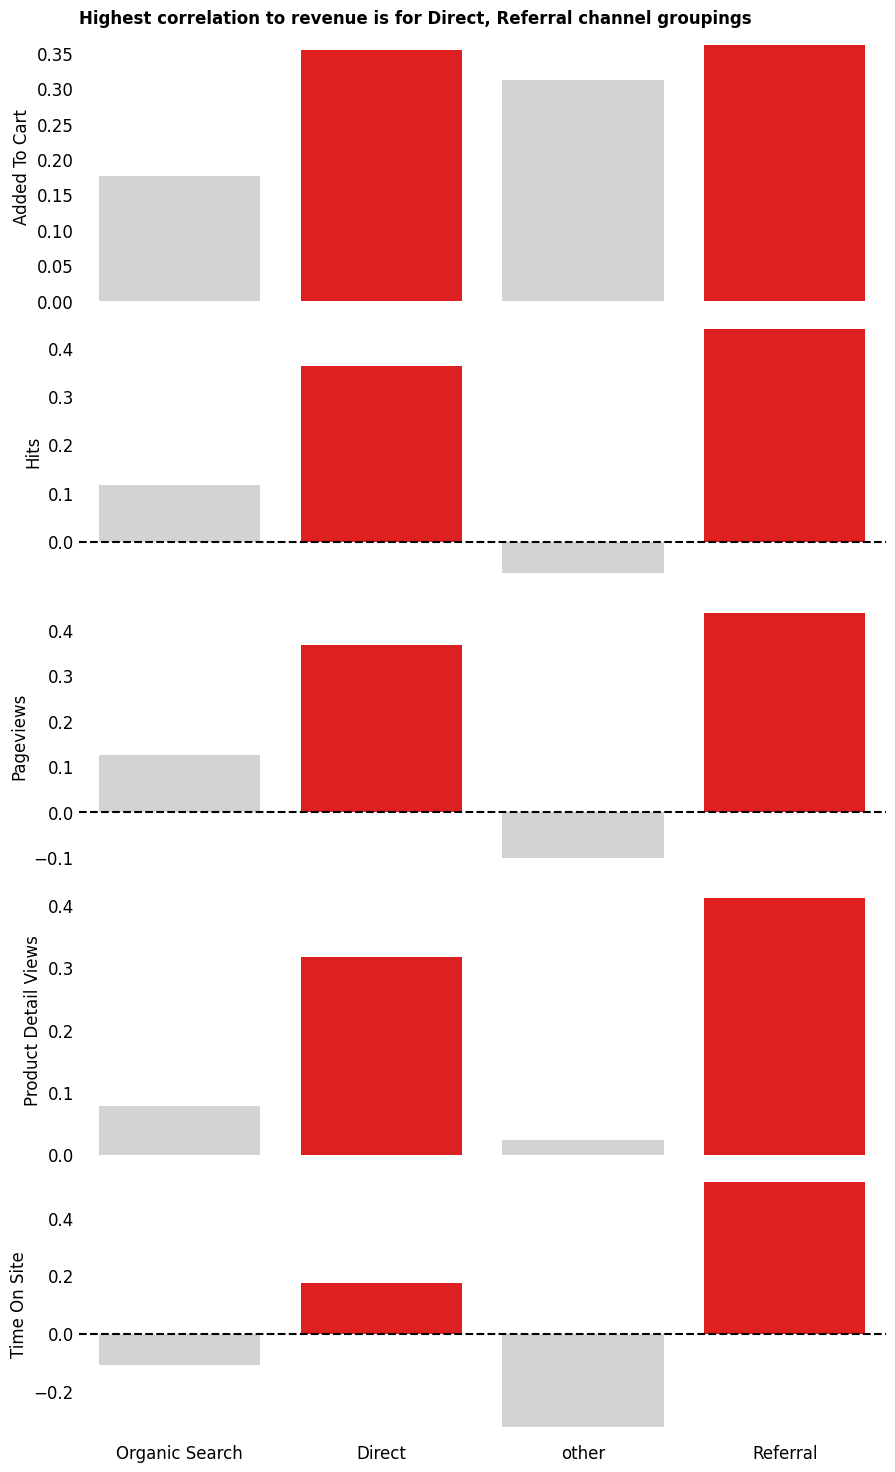

In [22]:
# | code-fold: false
plot_faceted_grouped_bar_chart(
    data=df_corr_chn,
    xvar="channelGrouping",
    yvar="corr_to_1st_visit_revenue_if_return_purchase",
    zvar="first_visit_attribute",
    xvar_type="channel groupings",
    color_by_col="is_direct_referral",
    colors=["lightgrey", "red", "lightgrey", "red"],
    bar_order=["Organic Search", "Direct", "other", "Referral"],
    high_corr_categories=high_corr_categories,
)

::: {.callout-tip title="Observations"}

1. For the high-level channel groupings of (visitor) traffic source, direct and referral-based traffic are responsible for the highest correlation to revenue earned during the first visit by return purchasers (see the `corr_to_1st_visit_revenue_if_return_purchase` column). Combined, these two sources account for approximately 40% of all web traffic (first-time visitors) to the merchandise store's site.
2. Among all the selected numerical attributes of first-time visitors' visits to the store, the time spent on the site by first-time visitors reaching the store through referrals, and who later returned to make a purchase, (see `first_visit_attribute = time_on_site`) is most strongly correlated to visit revenue earned.
:::

The correlations are now similarly shown by the more fine-grained traffic source column

In [23]:
high_corr_categories = ["other", "mall.googleplex.com"]
df_corr_source = get_revenue_corr_by_attribute(df, "source", numerical_cols).assign(
    is_other_gmail=lambda df: df["source"].isin(high_corr_categories)
)
df_corr_source

,first_visit_attribute,source,corr_to_1st_visit_revenue_if_no_return_purchase,corr_to_1st_visit_revenue_if_return_purchase,proportion,is_other_gmail
1,added_to_cart,google,0.420159,0.210653,0.469773,False
0,added_to_cart,(direct),0.286862,0.354988,0.232726,False
2,added_to_cart,mall.googleplex.com,0.328478,0.476184,0.127238,True
4,added_to_cart,youtube.com,NaN,NaN,0.086666,False
3,added_to_cart,other,0.105265,0.486743,0.083597,True
6,hits,google,0.395540,0.027843,0.469773,False
5,hits,(direct),0.204795,0.362308,0.232726,False
7,hits,mall.googleplex.com,0.182408,0.679037,0.127238,True
9,hits,youtube.com,NaN,NaN,0.086666,False
8,hits,other,0.112838,0.470637,0.083597,True


::: {.callout-note title="Notes"}

1. [Traffic source](https://support.google.com/analytics/answer/1033173?hl=en&ref_topic=6010089) is the domain through which visitors reach the store's website ([link](https://www.wholewhale.com/tips/source-vs-medium-google-analytics/)).
2. Direct traffic source indicates a visitor entered the url of the store into the search bar on a browser and so *directly* accessed the store's site ([link](https://www.megalytic.com/blog/understanding-direct-traffic-in-google-analytics)).
:::

::: {.callout-tip title="Observations"}

1. Direct traffic sources again appear as one of the highest correlations (see the `corr_to_1st_visit_revenue_if_return_purchase` column) to first-visit revenue earned by return purchasers for all the numerical columns (`pageviews`, `hits`, etc.), but
   - gmail
   - `other` (less frequent)

   traffic sources have a stronger correlation to revenue.
2. A Google search (through the Google search engine, or `source = google`) during the first visit consistently has the weakest correlation to revenue earned during that visit for all numerical columns.
3. Correlations to revenue are stronger at this more granular level (by traffic source) than by the high-level channel groupings. For example, compare correlations in `corr_to_1st_visit_revenue_if_return_purchase` for `first_visit_attribute = hits` in `df_corr_chn` to the same in `df_corr_source`.
:::

This is finally repeated using the same helper function for the traffic medium column

In [24]:
high_corr_categories = ["referral", "(none)"]
df_corr_medium = get_revenue_corr_by_attribute(df, "medium", numerical_cols).assign(
    is_none_referral=lambda df: df["medium"].isin(high_corr_categories)
)
df_corr_medium

,first_visit_attribute,medium,corr_to_1st_visit_revenue_if_no_return_purchase,corr_to_1st_visit_revenue_if_return_purchase,proportion,is_none_referral
1,added_to_cart,organic,0.458317,0.176038,0.416851,False
3,added_to_cart,referral,0.193514,0.361836,0.271029,True
0,added_to_cart,(none),0.286862,0.354988,0.232726,True
2,added_to_cart,other,0.262166,0.315144,0.079394,False
5,hits,organic,0.435311,0.117423,0.416851,False
7,hits,referral,0.055521,0.439544,0.271029,True
4,hits,(none),0.204795,0.362308,0.232726,True
6,hits,other,0.261931,-0.064471,0.079394,False
9,pageviews,organic,0.429002,0.124916,0.416851,False
11,pageviews,referral,0.044005,0.436655,0.271029,True


A plot of these correlations to revenue is shown below for return purchasers (`corr_to_1st_visit_revenue_if_return_purchase`)

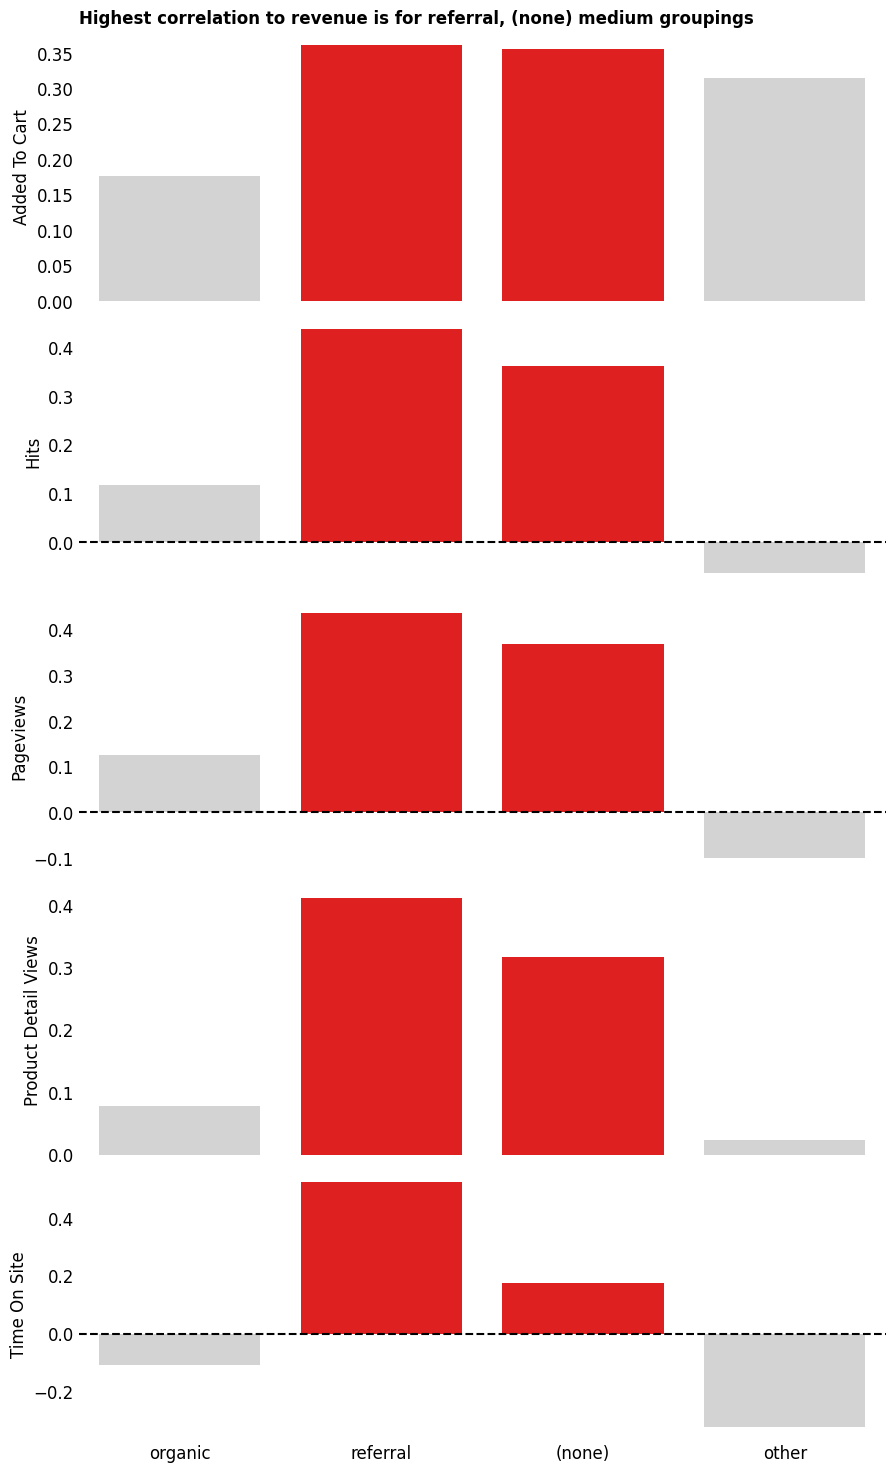

In [25]:
# | code-fold: false
plot_faceted_grouped_bar_chart(
    data=df_corr_medium,
    xvar="medium",
    yvar="corr_to_1st_visit_revenue_if_return_purchase",
    zvar="first_visit_attribute",
    xvar_type="medium groupings",
    color_by_col="is_none_referral",
    colors=["lightgrey", "red", "red", "lightgrey"],
    bar_order=["organic", "referral", "(none)", "other"],
    high_corr_categories=high_corr_categories,
)

::: {.callout-note title="Notes"}

1. Traffic medium reflects the type of traffic source that reaches the store's website ([link](https://www.wholewhale.com/tips/source-vs-medium-google-analytics/)).
2. Traffic medium is a more higher-level grouping of visitor traffic than traffic source.
3. `(none)` refers to traffic that originates from sources which tracking information is not available. Some reasons ([1](https://odd.dog/blog/how-to-determine-what-google-analytics-directnone-traffic-is-from/), [2](https://www.datadrivenu.com/direct-none-traffic-source-google-analytics/)) for this occurrence include a
   - visitor directly entering the url into a browser
   - visitor clicking a browser bookmark
   - visitor clicks a link in a PDF document
   - etc.
:::

::: {.callout-tip title="Observations"}

1. Again referrals appear as one of the strongest correlations to first-visit revenue. Unknown mediums give the second strongest correlation to revenue.
2. Correlations to revenue are weaker for this aggregation of traffic than by the lower-level traffic source grouping.
:::

::: {.callout-tip title="Overall Observations for Correlations to Revenue Based on Groupings by Traffic"}

1. Revenue earned during a first visit to the merchandise store is most strongly correlated to numerical attributes of the first visit for referral-based or direct/unknown traffic sources.
2. Attributes of visitors reaching the site through a Google search have the weakest correlation to first-visit revenue earned.
3. hits and pageviews are correlated to eachother. These two attributes are also correlated to product detail views, although this is weaker than the correlation between hits and pageviews. We can see the inter-correlation between these three columns from the similar
   - values in the respective `DataFrames` (`df_corr_chn`, `df_corr_source` and `df_corr_medium`)
   - bar relative heights in the charts
:::

**Question 2. Which channels were responsible for the most first-time visitors with a purchase on their return visit? Show this comparison on a chart by channel.**

In [26]:
# | code-fold: false
df_agg_by_channel = (
    # groupby and count fullvisitorid
    df.groupby(["made_purchase_on_future_visit", "channelGrouping"], as_index=False)[
        "fullvisitorid"
    ]
    .count()
    .rename(columns={"fullvisitorid": "num_visitors"})
    # LEFT JOIN with frequency counts by outcome (whether purchase was made or not)
    .merge(
        df["made_purchase_on_future_visit"]
        .value_counts()
        .rename("total_visitors")
        .reset_index(),
        on="made_purchase_on_future_visit",
        how="left",
    )
    # calculate fraction from count
    .assign(frac_visitors=lambda df: 100 * df["num_visitors"] / df["total_visitors"])
    # ORDER BY for display purposes only
    .sort_values(by=["made_purchase_on_future_visit", "num_visitors"], ascending=False)
)
df_agg_by_channel

,made_purchase_on_future_visit,channelGrouping,num_visitors,total_visitors,frac_visitors
6,True,Referral,1841,4250,43.317647
4,True,Direct,1642,4250,38.635294
5,True,Organic Search,579,4250,13.623529
7,True,other,188,4250,4.423529
1,False,Organic Search,38001,88301,43.035753
0,False,Direct,19897,88301,22.533154
3,False,other,16086,88301,18.217234
2,False,Referral,14317,88301,16.213859


A plot showing the fraction of return purchasers by channel (`frac_visitors`) is shown below

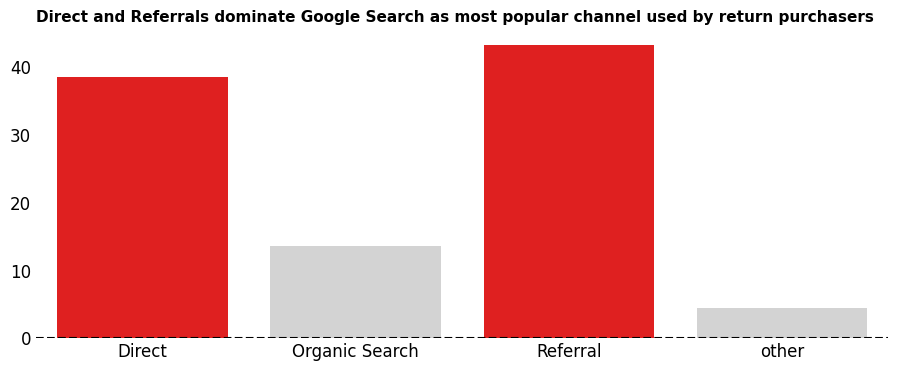

In [27]:
# | code-fold: false
fig = plt.figure(figsize=(11, 4))
grid = plt.GridSpec(1, 1)
ax1 = fig.add_subplot(grid[0, 0])

for ax, c in zip([ax1], [True]):
    data = df_agg_by_channel.query(f"made_purchase_on_future_visit == {c}")
    sns.barplot(
        x=data["channelGrouping"],
        y=data["frac_visitors"],
        palette=["red", "lightgrey", "red", "lightgrey"],
        ax=ax,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.tick_params(size=0)
    ax.axhline(0, ls="--", c="black")
    ax.set_title(
        (
            "Direct and Referrals dominate Google Search as most "
            "popular channel used by return purchasers"
        ),
        loc="left",
        fontweight="bold",
        fontsize=11,
    )
    ax = customize_splines(ax, None)

::: {.callout-tip title="Observations"}

1. (From the table `df_agg_by_channel`) Organic Search (Google search engine) and direct arrivals are the two dominant sources of first-time visitors to the site who do not make a purchase on a return visit.
2. (From the chart) By comparison, when visitors who do make a purchase on their return visit reach the site, they are reaching the store through referrals (eg. NYTimes.com, etc.) or by directly entering the URL directly into their browser search bar. Organic search accounts for a relatively smaller fraction of such return purchasers.
:::

**Question 3. Is there any one web-browser that return purchasers used on their first visit?**

In [28]:
# | code-fold: false
df_agg_by_browser = (
    # groupby and count fullvisitorid
    df.groupby(["made_purchase_on_future_visit", "browser"], as_index=False)[
        "fullvisitorid"
    ]
    .count()
    .rename(columns={"fullvisitorid": "num_visitors"})
    # LEFT JOIN with frequency counts by outcome (whether purchase was made or not)
    .merge(
        df["made_purchase_on_future_visit"]
        .value_counts()
        .rename("total_visitors")
        .reset_index(),
        on="made_purchase_on_future_visit",
        how="left",
    )
    # calculate fraction from count
    .assign(frac_visitors=lambda df: 100 * df["num_visitors"] / df["total_visitors"])
    # ORDER BY for display purposes only
    .sort_values(by=["made_purchase_on_future_visit", "num_visitors"], ascending=False)
)
df_agg_by_browser

,made_purchase_on_future_visit,browser,num_visitors,total_visitors,frac_visitors
3,True,Chrome,4102,4250,96.517647
4,True,Safari,95,4250,2.235294
5,True,other,53,4250,1.247059
0,False,Chrome,64899,88301,73.497469
1,False,Safari,15199,88301,17.212716
2,False,other,8203,88301,9.289816


A plot showing the fraction of return purchasers by web browser (`frac_visitors`) is shown below

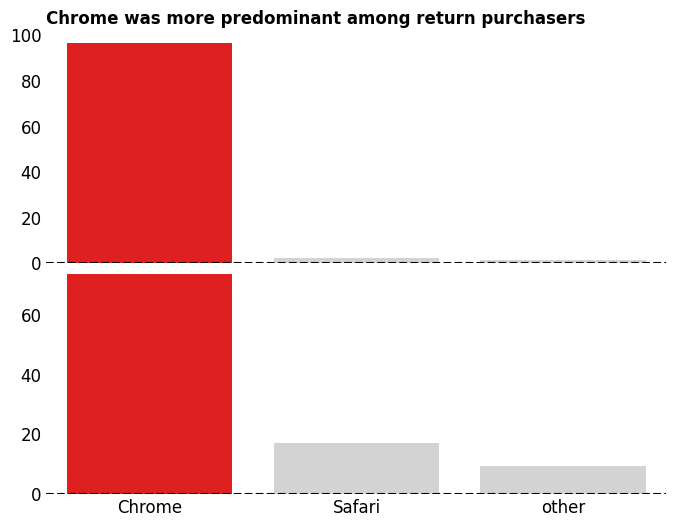

In [29]:
# | code-fold: false
fig = plt.figure(figsize=(8, 6))
grid = plt.GridSpec(2, 1, hspace=0)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])

for ax, c in zip([ax1, ax2], [True, False]):
    data = df_agg_by_browser.query(f"made_purchase_on_future_visit == {c}")
    sns.barplot(
        x=data["browser"],
        y=data["frac_visitors"],
        palette=["red", "lightgrey", "lightgrey"],
        ax=ax,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.tick_params(size=0)
    ax.axhline(0, ls="--", c="black")
    if c:
        ax.set_title(
            "Chrome was more predominant among return purchasers",
            loc="left",
            fontweight="bold",
        )
        ax.set_xticklabels([])
    ax = customize_splines(ax, None)

::: {.callout-tip title="Observations"}

1. Google Chrome is the dominant browser used during the first visit by visitors who return to make a future purchase.
2. There are more first-time visitors that access the store using Safari using that visit who don't make a purchase on their return visit, but even in this case Chrome is more frequently used.
:::

**Question 4. Do visitors who make a purchase on their return visit to the store have a preference for the type of device (desktop, mobile, etc.) they are using during their first visit?**

In [30]:
# | code-fold: false
df_agg_by_device = (
    # groupby and count fullvisitorid
    df.groupby(["made_purchase_on_future_visit", "deviceCategory"], as_index=False)[
        "fullvisitorid"
    ]
    .count()
    .rename(columns={"fullvisitorid": "num_visitors"})
    # LEFT JOIN with frequency counts by outcome (whether purchase was made or not)
    .merge(
        df["made_purchase_on_future_visit"]
        .value_counts()
        .rename("total_visitors")
        .reset_index(),
        on="made_purchase_on_future_visit",
        how="left",
    )
    # calculate fraction from count
    .assign(frac_visitors=lambda df: 100 * df["num_visitors"] / df["total_visitors"])
    # ORDER BY for display purposes only
    .sort_values(by=["made_purchase_on_future_visit", "num_visitors"], ascending=False)
)
df_agg_by_device

,made_purchase_on_future_visit,deviceCategory,num_visitors,total_visitors,frac_visitors
3,True,desktop,4091,4250,96.258824
4,True,mobile,131,4250,3.082353
5,True,tablet,28,4250,0.658824
0,False,desktop,63264,88301,71.645848
1,False,mobile,21659,88301,24.528601
2,False,tablet,3378,88301,3.825551


A plot showing the fraction of return purchasers by type of computing device (`frac_visitors`) is shown below

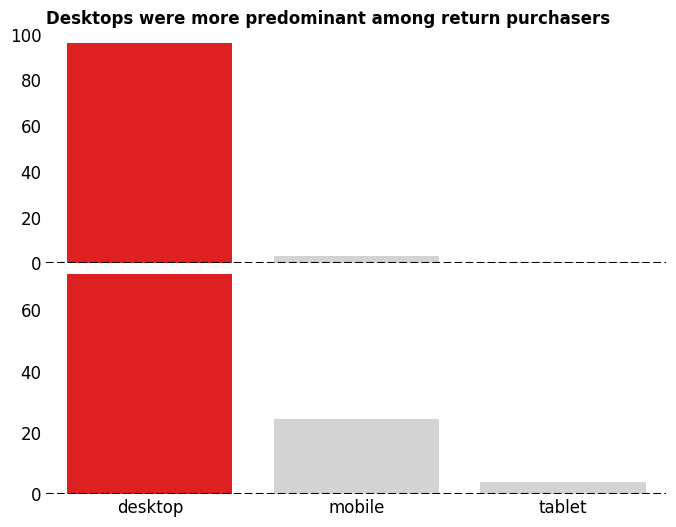

In [31]:
# | code-fold: false
fig = plt.figure(figsize=(8, 6))
grid = plt.GridSpec(2, 1, hspace=0)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])

for ax, c in zip([ax1, ax2], [True, False]):
    data = df_agg_by_device.query(f"made_purchase_on_future_visit == {c}")
    sns.barplot(
        x=data["deviceCategory"],
        y=data["frac_visitors"],
        palette=["red", "lightgrey", "lightgrey"],
        ax=ax,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.tick_params(size=0)
    ax.axhline(0, ls="--", c="black")
    if c:
        ax.set_title(
            "Desktops were more predominant among return purchasers",
            loc="left",
            fontweight="bold",
        )
        ax.set_xticklabels([])
    ax = customize_splines(ax, None)

::: {.callout-note title="Notes"}

1. This dataset was from 2016-2017. As use of mobile phones grown since then, these numbers may have changed in favor of increased use of mobile devices (even if desktop remains the dominant type of device being currently used).
:::

::: {.callout-tip title="Observations"}

1. There are relatively more visitors whow use their mobile phones for their initial visit and who don't make a return purchase than those that do return to make a purchase. Nonetheless, regardless of whether a future purchase is made, first-time visitors are overwhelmingly accessing the store's website from their desktops.
:::

**Question 5. Which traffic sources were responsible for the most return purchasers on weekdays and weekends?**

The following columns will be used for the questions involving `datetime` attributes

1. `fullvisitorid`
2. `month` (1 - 12)
3. `day_of_month` (1 - 31)
4. `day_of_week` (1 - 7)
5. `hour`
6. `source` (traffic source  after grouping)
7. `made_purchase_on_future_visit` (ML label column, `y`)

In [32]:
datetime_label_cols = [
    "fullvisitorid",
    "month",
    "day_of_month",
    "day_of_week",
    "hour",
    "source",
    "made_purchase_on_future_visit",
]

Show the `fullvisitorid`, `datetime` and ML label (`y`) columns from the prepared data

In [33]:
df[datetime_label_cols].head()

,fullvisitorid,month,day_of_month,day_of_week,hour,source,made_purchase_on_future_visit
0,483329569933708956,10,25,3,19,google,False
1,9534112552538425546,10,16,1,22,youtube.com,False
2,4648924122067625674,10,8,7,16,youtube.com,False
3,2743152869399749836,12,8,5,15,google,False
4,1565213706199847638,9,29,5,14,google,False


Definie mapping dictionaries to change month and day of week from integers to strings (month name and day name)

In [34]:
# | code-fold: false
month_mapper = dict(zip(range(1, 12 + 1), month_name[1:]))
day_mapper = dict(zip(range(1, 7 + 1), [day_name[-1]] + day_name[:-1]))

Apply these mapping dictionaries to the prepared data to get new columns with the `_name` suffix and append a column to indicate if the day of the week is a weekday or weekend

In [35]:
# | code-fold: false
df_datetime = (
    # map month to month name
    df.assign(month_name=lambda df: df["month"].map(month_mapper))
    # map day of week to day name
    .assign(day_name=lambda df: df["day_of_week"].map(day_mapper))
    # map day of week to weekend check (boolean column)
    .assign(is_weekend=lambda df: df["day_of_week"].isin([1, 7]))
)
df_datetime[
    datetime_label_cols[:-1]
    + ["month_name", "is_weekend", "day_name"]
    + [datetime_label_cols[-1]]
].head()

,fullvisitorid,month,day_of_month,day_of_week,hour,source,month_name,is_weekend,day_name,made_purchase_on_future_visit
0,483329569933708956,10,25,3,19,google,October,False,Tuesday,False
1,9534112552538425546,10,16,1,22,youtube.com,October,True,Sunday,False
2,4648924122067625674,10,8,7,16,youtube.com,October,True,Saturday,False
3,2743152869399749836,12,8,5,15,google,December,False,Thursday,False
4,1565213706199847638,9,29,5,14,google,September,False,Thursday,False


Perform the `GROUP BY` over

1. traffic source
2. `is_weekend`
3. whether return purchase was made

and get fraction of visitors

In [36]:
# | code-fold: false
df_datetime_agg_source = (
    # groupby and count fullvisitorid
    df_datetime.groupby(
        ["source", "is_weekend", "made_purchase_on_future_visit"],
        as_index=False,
    )
    .agg({"fullvisitorid": "count"})
    .rename(columns={"fullvisitorid": "num_visitors"})
    .sort_values(by=["made_purchase_on_future_visit", "source"])
    # LEFT JOIN with frequency counts by outcome (whether purchase was made or not)
    .merge(
        df["made_purchase_on_future_visit"]
        .value_counts()
        .rename("total_visitors")
        .reset_index(),
        on="made_purchase_on_future_visit",
        how="left",
    )
    # calculate fraction from count
    .assign(frac_visitors=lambda df: 100 * df["num_visitors"] / df["total_visitors"])
)
df_datetime_agg_source

,source,is_weekend,made_purchase_on_future_visit,num_visitors,total_visitors,frac_visitors
0,(direct),False,False,16220,88301,18.368988
1,(direct),True,False,3677,88301,4.164166
2,google,False,False,32439,88301,36.736843
3,google,True,False,10344,88301,11.714477
4,mall.googleplex.com,False,False,9349,88301,10.587649
5,mall.googleplex.com,True,False,1149,88301,1.301231
6,other,False,False,5947,88301,6.734918
7,other,True,False,1158,88301,1.311423
8,youtube.com,False,False,5883,88301,6.662439
9,youtube.com,True,False,2135,88301,2.417866


A heatmap is shown below for return purchasers (`frac_visitors`) and similarly for visitors who did not make a purchase on a return visit

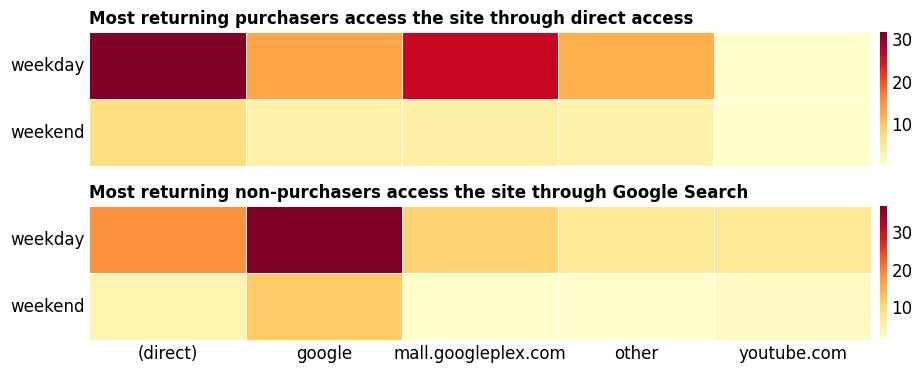

In [37]:
# | code-fold: false
fig = plt.figure(figsize=(12, 4))
grid = plt.GridSpec(2, 1, hspace=0.3)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])

for ax, c, ptitle_substr, source in zip(
    [ax1, ax2],
    [True, False],
    ["returning purchasers", "returning non-purchasers"],
    ["direct access", "Google Search"],
):
    data = (
        # filter
        (
            df_datetime_agg_source.query(
                f"made_purchase_on_future_visit == {c}"
            ).assign(
                is_weekend=lambda df: df["is_weekend"].map(
                    {False: "weekday", True: "weekend"}
                )
            )
        )
        # reshape for heatmap
        .pivot(
            index="source",
            columns="is_weekend",
            values="frac_visitors",
        )
        .astype(float)
        .transpose()
    )

    # plot heatmap
    ax = sns.heatmap(data, cmap="YlOrRd", cbar_kws={"pad": 0.01}, linewidth=0.5, ax=ax)

    # customize heatmap
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12, rotation=0)
    ax.set_title(
        f"Most {ptitle_substr} access the site through {source}",
        loc="left",
        fontweight="bold",
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(size=0, labelsize=12)
    if c:
        ax.set_xticklabels([])
    ax.tick_params(size=0)

::: {.callout-tip title="Observations"}

1. Direct channels and referrals were the found earlier to be the dominant channels used by return purchasers (`made_purchase_on_future_visit = True`). So it is not surprising that the same two sources are the dominant ones bringing return purchasers to the site on weekedays and weekends in the top subplot. Among referrals, Gmail is the dominant referral source bringing return purchasers to the store.
:::

**Question 6. Show the fraction of visitors who did make a purchase on their return visit to the merchandise store by month and day of the month.**

In [38]:
# | code-fold: false
df_agg = df.groupby(["month", "day_of_month"], as_index=False).agg(
    {"made_purchase_on_future_visit": ["sum"], "fullvisitorid": "count"}
)
df_agg.columns = ["_".join(c).rstrip("_") for c in df_agg.columns.to_flat_index()]
df_agg = df_agg.rename(
    columns={
        "made_purchase_on_future_visit_sum": "return_purchasers",
        "fullvisitorid_count": "return_visitors",
    }
).assign(
    frac_return_purchasers=lambda df: 100
    * df["return_purchasers"]
    / df["return_visitors"]
)
display(df_agg.head())
display(df_agg.tail())

,month,day_of_month,return_purchasers,return_visitors,frac_return_purchasers
0,1,1,1,39,2.564103
1,9,1,18,643,2.799378
2,9,2,17,647,2.627512
3,9,3,5,408,1.22549
4,9,4,6,350,1.714286


,month,day_of_month,return_purchasers,return_visitors,frac_return_purchasers
118,12,27,34,665,5.112782
119,12,28,30,577,5.199307
120,12,29,22,588,3.741497
121,12,30,13,436,2.981651
122,12,31,15,439,3.416856


Reshape into untidy data for heatmap

In [39]:
# | code-fold: false
data = (
    df_agg.query("month >= 9")
    .assign(month_name=lambda df: df["month"].map(month_mapper))
    .pivot(index="day_of_month", columns="month_name", values="frac_return_purchasers")
    .astype(float)[month_name[1:][-4:]]
)
data.reset_index()

month_name,day_of_month,September,October,November,December
0,1,2.799378,2.094241,6.130790,5.904059
1,2,2.627512,1.670644,5.576679,5.989305
2,3,1.225490,4.066265,6.161137,3.909774
3,4,1.714286,2.702703,5.153203,5.652174
4,5,2.444444,3.389831,5.772812,7.899306
5,6,1.834862,2.423469,6.654676,6.147541
6,7,2.624672,2.497027,8.690013,6.353861
7,8,2.627737,1.720841,4.913295,5.579399
8,9,3.285714,1.691729,6.239737,5.838041
9,10,2.127660,4.490291,6.200528,4.596273


Show heatmap

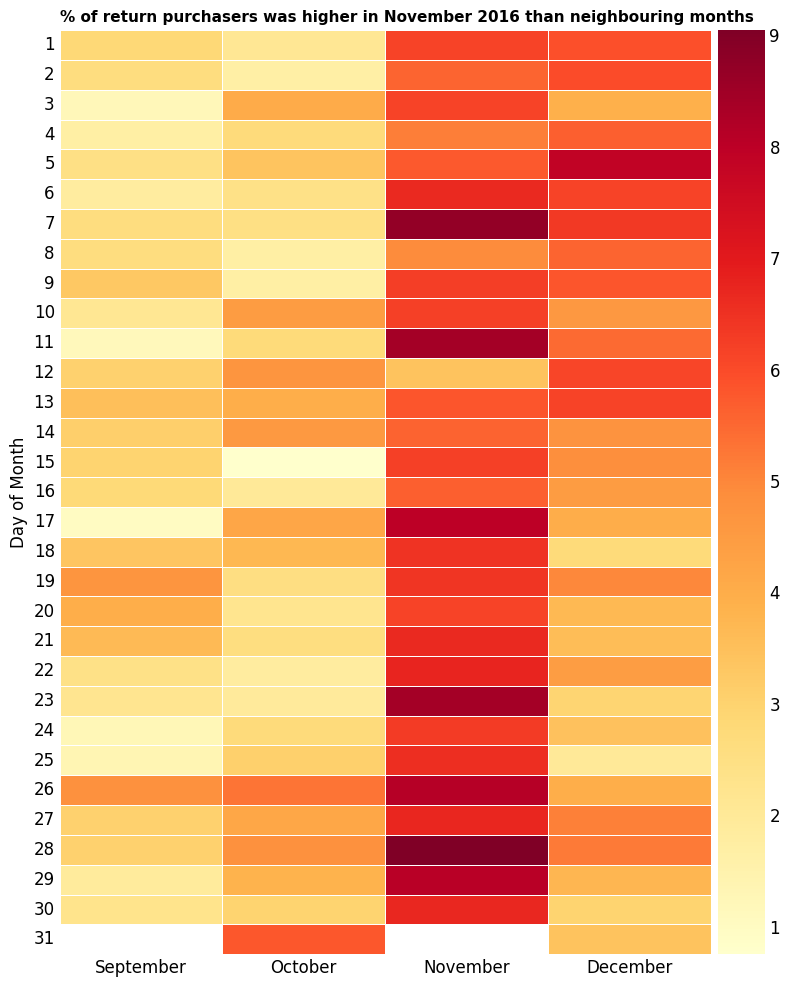

In [40]:
# | code-fold: false
show_heatmap(
    data,
    "Day of Month",
    "% of return purchasers was higher in November 2016 than neighbouring months",
    {"pad": 0.01},
    fig_size=(10, 12),
)

::: {.callout-tip title="Observations"}

1. The fraction of daily visitors who made a purchase on their return visit to the store (or, *return purchasers*) peaked during November 2016 before dropping in December. This trend not only implies seasonality in bulk buying trends at the store but also, the higher fraction before Christmas and the New Year festivities is critical to the store’s strategic planning.
:::

**Question 7. Show the fraction of visitors who made a purchase on their return visit to the merchandise store by month and day of the week.**

Aggregate to get number of

- visitors
- channels

used by visitors who did and did not make purchase on a return visit

In [41]:
# | code-fold: false
df_agg = df.groupby(
    ["month", "day_of_week", "made_purchase_on_future_visit"], as_index=False
).agg({"fullvisitorid": "count", "channelGrouping": "nunique"})
df_agg = df_agg.rename(
    columns={"channelGrouping": "num_channels", "fullvisitorid": "return_visitors"}
)
df_agg.head()

,month,day_of_week,made_purchase_on_future_visit,return_visitors,num_channels
0,1,1,False,38,4
1,1,1,True,1,1
2,9,1,False,1577,4
3,9,1,True,30,4
4,9,2,False,2477,4


Pivot the data so that the number of visitors who did and did not make a return purchase are shown as separate columns (repeat for number of channels used by visitors who did and did not make a return purchase)

In [42]:
# | code-fold: false
df_agg_untidy = df_agg.pivot(
    index=["month", "day_of_week"],
    columns=["made_purchase_on_future_visit"],
    values=["return_visitors", "num_channels"],
).reset_index()
df_agg_untidy.columns = [
    "_".join([str(c) for c in c_list]).rstrip("_")
    for c_list in df_agg_untidy.columns.to_flat_index()
]
df_agg_untidy.head()

,month,day_of_week,return_visitors_False,return_visitors_True,num_channels_False,num_channels_True
0,1,1,38,1,4,1
1,9,1,1577,30,4,4
2,9,2,2477,100,4,4
3,9,3,2645,85,4,4
4,9,4,2910,93,4,4


Get total number of visitors and channels

In [43]:
# | code-fold: false
df_agg_untidy["num_channels"] = (
    df_agg_untidy["num_channels_False"] + df_agg_untidy["num_channels_True"]
)
df_agg_untidy["return_visitors"] = (
    df_agg_untidy["return_visitors_False"] + df_agg_untidy["return_visitors_True"]
)
df_agg_untidy.head()

,month,day_of_week,return_visitors_False,return_visitors_True,num_channels_False,num_channels_True,num_channels,return_visitors
0,1,1,38,1,4,1,5,39
1,9,1,1577,30,4,4,8,1607
2,9,2,2477,100,4,4,8,2577
3,9,3,2645,85,4,4,8,2730
4,9,4,2910,93,4,4,8,3003


Convert number of visitors and channels into fractions of visitors and channels

In [44]:
# | code-fold: false
df_agg_untidy["frac_channels_used_by_return_purchasers"] = 100 * (
    df_agg_untidy["num_channels_True"] / df_agg_untidy["num_channels"]
)
df_agg_untidy["frac_return_purchasers"] = 100 * (
    df_agg_untidy["return_visitors_True"] / df_agg_untidy["return_visitors"]
)
df_agg_untidy.sample(5)

,month,day_of_week,return_visitors_False,return_visitors_True,num_channels_False,num_channels_True,num_channels,return_visitors,frac_channels_used_by_return_purchasers,frac_return_purchasers
7,9,7,1609,23,4,4,8,1632,50.0,1.409314
22,12,1,2633,114,4,4,8,2747,50.0,4.149982
15,11,1,2430,166,4,4,8,2596,50.0,6.394453
18,11,4,4004,281,4,4,8,4285,50.0,6.557760
4,9,4,2910,93,4,4,8,3003,50.0,3.096903


Melt data to get back to `GROUP BY` format, and only keep columns with fractions (drop columns with numbers)

In [45]:
# | code-fold: false
df_agg_tidy = df_agg_untidy.melt(
    id_vars=["month", "day_of_week"],
    value_vars=["frac_channels_used_by_return_purchasers", "frac_return_purchasers"],
)
df_agg_tidy.head()

,month,day_of_week,variable,value
0,1,1,frac_channels_used_by_return_purchasers,20.0
1,9,1,frac_channels_used_by_return_purchasers,50.0
2,9,2,frac_channels_used_by_return_purchasers,50.0
3,9,3,frac_channels_used_by_return_purchasers,50.0
4,9,4,frac_channels_used_by_return_purchasers,50.0


Reshape into untidy data for heatmap

In [46]:
# | code-fold: false
data = (
    df_agg_tidy.query("month >= 9")
    .query("variable == 'frac_return_purchasers'")
    .assign(day_name=lambda df: df["day_of_week"].map(day_mapper))
    .assign(month_name=lambda df: df["month"].map(month_mapper))
    .pivot(index="day_name", columns="month_name", values="value")
    .loc[list(day_name)][month_name[1:][-4:]]
)
data

month_name,September,October,November,December
day_name,,,,
Monday,3.880481,4.226082,7.741935,6.023815
Tuesday,3.113553,3.009504,6.656243,5.300023
Wednesday,3.096903,4.055525,6.557760,4.974037
Thursday,2.571116,3.224825,6.718891,5.071080
Friday,2.657510,3.602058,6.650016,4.810249
Saturday,1.409314,2.041633,6.209292,3.981043
Sunday,1.866833,2.089783,6.394453,4.149982


Show heatmap

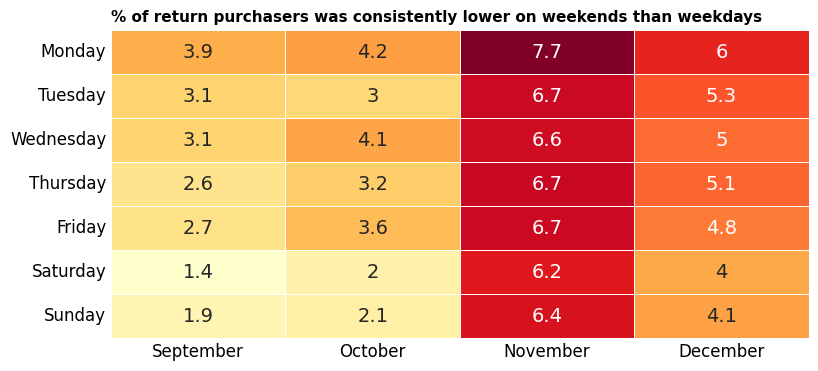

In [47]:
# | code-fold: false
show_heatmap(
    data,
    None,
    "% of return purchasers was consistently lower on weekends than weekdays",
    False,
    annot_kws={"size": 14},
    fig_size=(9, 4),
)

::: {.callout-tip title="Observations"}

1. The pool of visitors who are return purchasers shows weak evidence of following the structure of the work week since the fraction of return purchasers dropped on weekends (Saturday and Sunday) compared to weekedays.
:::

**Question 8. Show the breakdown of total revenue earned by visitors who are return purchasers and those that are not return purchasers.**

In [48]:
df.groupby(["made_purchase_on_future_visit"])[
    "transact_revenue"
].sum().reset_index().assign(
    total_first_visit_revenue=lambda df: df["transact_revenue"].sum()
).assign(
    frac_transact_revenue=lambda df: 100
    * df["transact_revenue"]
    / df["total_first_visit_revenue"]
).query(
    "made_purchase_on_future_visit == True"
)

,made_purchase_on_future_visit,transact_revenue,total_first_visit_revenue,frac_transact_revenue
1,True,89350.15625,484412.15625,18.44507


::: {.callout-tip title="Observations"}

1. Return purchasers account for nearly 20% of total revenue earned during the first visit.
:::

## Key Findings

1. Products and promotions on the store's website are not being viewed or clicked often by first-time visitors to the site.
2. During the months covered by the training data, only
   - 10% of all visitors to the store added a product to their shopping cart during their first visit
   - 4% of all first-time visitors to the store made a purchase on a return visit
3. Correlations between numerical attributes of visitors' first visits and revenue earned during the first visit
   - grouping traffic by channel
     - direct traffic and referrals account for approximately 40% of all return purchasers and are responsible for the highest correlation to revenue earned during the first visit by visitors who returned to make a purchase during a return (future) visit.
   - grouping visitor traffic by source
     - gmail and the combined `other` (less frequently used) traffic sources show the highest correlation to revenue. Direct sources ranks third.
     - correlations are stronger at the source level (more granular) than at the channel or traffic medium level (both of which are higher-level groupings of traffic sources)
     - some of the columns namely hits, pageviews and products with detail views are correlated to eachother, so one or more of these features should be excluded during ML development
4. Google Chrome is the dominant browser used during the first visit of visitors who return to make a future purchase.
5. For those visitors that do return and make a future purchase, they are predominantly doing so by accessing the store's site from a desktop computer.
6. By traffic source, direct channels and referrals are the dominant sources bringing return purchasers to the site on both weekedays and weekends.
7. Return purchasers peaked during November 2016 before dropping in December.
8. Return purchasers were higher in number on weekdays than on weekends.

## Summary of Assumptions

None.

## Summary of Tasks Performed

This step has performed non-exhaustive EDA for insights into the prepared data.

## Limitations

1. Limited EDA has been performed. For columns for which we have not performed EDA, we will be relying on our intuition to determine whether they will be useful as ML features.

## Next Step

The next step will transform the raw data in this dataset, in order to prepare it for machine learning, as follows

1. extract the attributes of each visit that were recommended in this step
2. drop duplicates by `fullvisitorid`
3. handle high-cardinality categorical columns

This will be done separately for training, validation and test data splits. As with the (current) EDA step, we will again use the learnings from data preparation in order to avoid preparing data for ML development that suffers from data leakage/lookahead bias.

The data will first be split into training, validation and test splits before
1. dropping duplicates
2. creating a lookup table using the training data to create category groupings for the categorical features
   - as shown in this step, these groupings are used to address the issue of high-cardinality categorical features during ML model development

---